# Mixed Layer Function

**GOAL:** Calculate properties of a mixed layer

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.io import get_upper_air_data
from metpy.plots import SkewT
from metpy.units import units
import numpy as np
from metpy.constants import kappa
%matplotlib inline

In [2]:
# Download and parse the data
dataset = get_upper_air_data(datetime(1999, 5, 4, 0), 'OUN')

p = dataset.variables['pressure'][:]
T = dataset.variables['temperature'][:]
Td = dataset.variables['dewpoint'][:]
u = dataset.variables['u_wind'][:]
v = dataset.variables['v_wind'][:]

In [3]:
def mixed_layer(p, datavar, bottom=None, depth=100*units.hPa, interpolate=True):
    p_layer, datavar_layer = mpcalc.get_layer(p, datavar, bottom, depth, interpolate)
    actual_depth = abs(p_layer[0] - p_layer[-1])
    datavar_mean = (1./actual_depth.m) * np.trapz(datavar_layer, p_layer) * datavar.units
    return datavar_mean

In [11]:
def mixed_parcel(p, T, Td, parcel_start_pressure=p[0], bottom=None, depth=100*units.hPa, interpolate=True):
    
    # Get the variables in the layer
    p_layer, T_layer = mpcalc.get_layer(p, T, bottom, depth, interpolate)
    p_layer, Td_layer = mpcalc.get_layer(p, Td, bottom, depth, interpolate)
    
    # Calculate the potential temperature and mixing ratio over the layer
    theta = mpcalc.potential_temperature(p, T)
    mixing_ratio = mpcalc.saturation_mixing_ratio(p, Td)
    
    # Mix the variables over the layer
    mean_theta = mixed_layer(p, theta, bottom, depth, interpolate)
    mean_mixing_ratio = mixed_layer(p, mixing_ratio, bottom, depth, interpolate)
    
    # Convert back to temperature
    mean_temperature = mean_theta / mpcalc.potential_temperature(parcel_start_pressure, 1 * units.degK).m
    
    # Convert back to dewpoint
    mean_vapor_pressure = mpcalc.vapor_pressure(parcel_start_pressure, mean_mixing_ratio)
    mean_dewpoint = mpcalc.dewpoint(mean_vapor_pressure)
    
    return parcel_start_pressure, mean_temperature.to(T.units), mean_dewpoint.to(Td.units)

(10, 25)

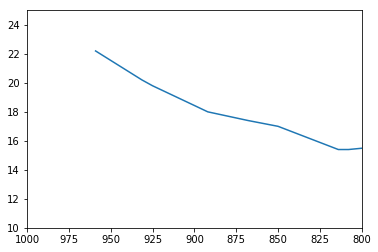

In [12]:
plt.plot(p, T)
plt.xlim(1000, 800)
plt.ylim(10, 25)

In [13]:
mixed_layer(p, T)

[ 859.   867.9  892.   899.3  925.   931.3  959. ] hectopascal
[ 17.20111732  17.4         18.          18.4         19.8         20.2  22.2       ] degC
100.0 hectopascal
1917.51497207


<Quantity(19.17514972067039, 'degC')>

In [14]:
pl, tl = mpcalc.get_layer(p, T, bottom=3000*units.m, depth=2000*units.m, interpolate=True)

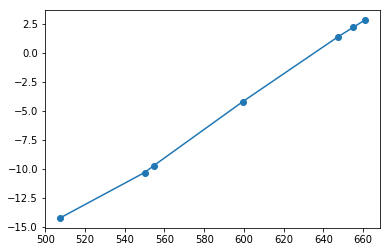

In [15]:
plt.plot(pl, tl, marker='o')

In [16]:
mixed_parcel(p, T, Td, depth=500*units.hPa)

[ 459.   472.5  500.   550.   554.7  599.4  647.5  655.   700.   724.3  751.3  779.2  790.   807.9  814.   850.   867.9  892.   899.3  925.  931.3  959. ] hectopascal
[ 317.43901382  316.57487188  314.79184743  311.7942788   311.7473893  311.28792788  310.84007098  310.72203094  310.19532423  309.81808894  309.41743131  309.00366175  308.86076963  306.67792009  306.0197208  303.93634398  302.54903507  300.81124879  300.52407484  299.54662685  299.37465065  298.90289633] degC
500.0 hectopascal
154269.735255
[ 459.   472.5  500.   550.   554.7  599.4  647.5  655.   700.   724.3  751.3  779.2  790.   807.9  814.   850.   867.9  892.   899.3  925.  931.3  959. ] hectopascal
[ 0.00142612  0.00152171  0.00172357  0.0021925   0.00215597  0.0018666  0.00160243  0.0015708   0.00255855  0.00239512  0.00223636  0.00208822  0.00202686  0.00517408  0.00692847  0.0107823   0.01189566  0.01362357  0.01359849  0.01338489  0.01364052  0.01457646] degC
500.0 hectopascal
2.50870858316


(<Quantity(959.0, 'hectopascal')>,
 <Quantity(31.72202945870839, 'degC')>,
 <Quantity(3.177487439626419, 'degC')>)

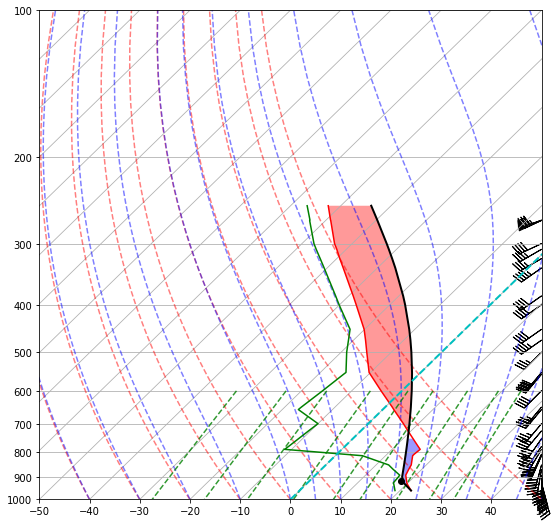

In [10]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
greater = T >= prof
skew.ax.fill_betweenx(p, T, prof, where=greater, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=~greater, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0
# isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()